# Пример расчета прямого и обратного прохода при обучении сети.

<img src='images/ris0_1.png' width=600, heigth=440> <br>
<img src='images/ris0_2.png' width=600, heigth=440> <br>
<img src='images/ris0_3.png' width=600, heigth=440> <br>
<img src='images/ris1_1.png' width=600, heigth=440> <br>
<img src='images/ris1_2.png' width=600, heigth=440> <br>


# Открытие датасета

# Импорты
Нужно установить PyTorch 

In [1]:
import math
import csv
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline


#---------
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.transforms.functional import normalize
import torchvision.datasets as dset

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from tqdm import tqdm
from sklearn.metrics import classification_report


In [5]:
#Возьмем данные из модуля datasets библиотеки Scikit-learn. Вначале загрузим их.
from sklearn import datasets
raw_data = datasets.load_wine()

In [6]:
# посмотрим на составляющие датасета
raw_data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [7]:
# определим тип данных нашего датасета
type(raw_data)

sklearn.utils.Bunch

In [9]:
# разбиение датасета на с цифрами на тестовый и обучающий
MNIST_train = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)
MNIST_test = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())


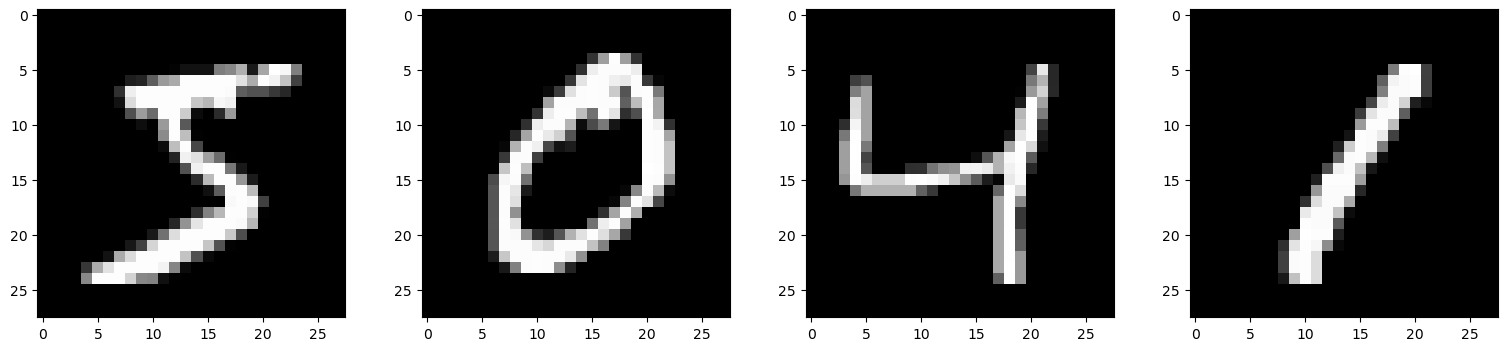

In [10]:
# отображение датасета с  цифрами
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4) 
ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(MNIST_train[i][0][0]), 'gray')
plt.show()

In [11]:
# создание класса perceptron
class Perceptron(torch.nn.Module):
    def __init__(self, input_dim=784, num_layers=0,
            hidden_dim=64, output_dim=10, p=0.0, device='cpu'): 
        super(Perceptron, self).__init__()
        self.layers = torch.nn.Sequential()
        prev_size = input_dim 
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), torch.nn.Linear(prev_size, hidden_dim)) 
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p)) 
            prev_size = hidden_dim
        self.layers.add_module('classifier',
            torch.nn.Linear(prev_size, output_dim))
        self.to(device)

    def forward(self, input):
        return self.layers(input)


In [12]:
# это объект, обозначающий устройство, на котором размещен или будет размещен torch.Tensor \
# Torch.device содержит тип устройства («процессор» или « cuda»)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device


device(type='cpu')

In [13]:
# Создание модели без внутренних слоев 
model = Perceptron(device=device) 
model

Perceptron(
  (layers): Sequential(
    (classifier): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [75]:

model = Perceptron(num_layers=5, device=device) 
model

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (layer1): Linear(in_features=64, out_features=64, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (layer2): Linear(in_features=64, out_features=64, bias=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.0, inplace=False)
    (layer3): Linear(in_features=64, out_features=64, bias=True)
    (relu3): ReLU()
    (dropout3): Dropout(p=0.0, inplace=False)
    (layer4): Linear(in_features=64, out_features=64, bias=True)
    (relu4): ReLU()
    (dropout4): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [14]:
# процедура терстирования модели 
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)
    pred = []
    real = []
    for x, y in tqdm(generator, leave=False):
        x = x.view([-1, 784]).to(device) 
        y = y.to(device)
        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist()) 
        real.extend(y.cpu().numpy().tolist())
    
    return np.mean(np.array(real) == np.array(pred)), classification_report(real, pred)


In [82]:
# процедура тренировки модели
def trainer(model, dataset, loss_function, optimizer, epochs): 
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64,
            shuffle=True)

        for x, y in tqdm(generator, leave=False):
            optimizer.zero_grad() 
            x = x.view([-1, 784]).to(device) 
            y = y.to(device)
            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()


In [83]:
model = Perceptron(num_layers=0, device=device)


In [84]:
# Результат, получаемый от необученной модели.
_ = model.eval()
acc, report = testing(model, MNIST_test) 
print(report)

              precision    recall  f1-score   support

           0       0.02      0.01      0.01       980
           1       0.02      0.01      0.01      1135
           2       0.05      0.03      0.04      1032
           3       0.43      0.02      0.05      1010
           4       0.13      0.25      0.17       982
           5       0.10      0.03      0.04       892
           6       0.02      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.15      0.89      0.25      1009

    accuracy                           0.12     10000
   macro avg       0.09      0.12      0.06     10000
weighted avg       0.09      0.12      0.06     10000



In [85]:
# Обучение модели
_ = model.train()
trainer(model=model,
    dataset=MNIST_train,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
    epochs=4)


 62%|█████████████████████████████████████████████████▋                              | 582/938 [00:18<00:15, 23.19it/s]


 23%|██████████████████▏                                                             | 213/938 [00:08<00:26, 27.24it/s]


 96%|████████████████████████████████████████████████████████████████████████████▌   | 897/938 [00:24<00:00, 48.12it/s]


 67%|█████████████████████████████████████████████████████▉                          | 633/938 [00:14<00:07, 41.03it/s]


 44%|███████████████████████████████████▎                                            | 414/938 [00:08<00:11, 46.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████▋| 935/938 [00:19<00:00, 46.53it/s]


In [86]:
# Результат обучения классификатора
_ = model.eval()
acc, report = testing(model, MNIST_test) 
print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.98      0.97      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.91      0.91      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.91      0.85      0.88       892
           6       0.93      0.95      0.94       958
           7       0.93      0.92      0.93      1028
           8       0.85      0.90      0.88       974
           9       0.90      0.91      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Задание: С помощью нейронной сети классифицировать вина по качеству. Датасет взять из третьей работы. Разбить датасет на два класса по качеству вина. Качество вина до пяти включительно определить как первый класс, свыше пяти - как второй.
Представить основные показатели метода. Сравнить результат классификации с результатом из третьей работы.